In [1]:
%matplotlib inline
from spacepy import pycdf
from matplotlib import pyplot as plt
from scipy import interpolate
import numpy as np
import datetime
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [2]:
mag_data = pycdf.CDF('data/wi_h0_mfi_20130117_v05.cdf')
plasma_momenta_data = pycdf.CDF('data/wi_pm_3dp_20130117_v05.cdf')
# print(mag_data,'\n')
# print(plasma_momenta_data)

In [3]:
epoch3sec_mag = mag_data['Epoch3'][...]
bGSE3sec = mag_data['B3GSE'][...]
bTotal3sec = mag_data['B3F1'][...]

n3sec = plasma_momenta_data['P_DENS'][...]
vGSE3sec = plasma_momenta_data['P_VELS'][...]
vTotal3sec = np.sqrt(vGSE3sec[:,0]**2+vGSE3sec[:,1]**2+vGSE3sec[:,2]**2)
epoch3sec_plasma_momenta = plasma_momenta_data['Epoch'][...]
Tproton3sec = plasma_momenta_data['P_TEMP'][...]

In [4]:
bGSE3sec[bGSE3sec<-10000] = np.nan
bTotal3sec[bTotal3sec<-10000] = np.nan

In [5]:
# fig, axes = plt.subplots(4,figsize=(10,10))
# ax = axes[0]
# ax.plot(epoch3sec_mag,bGSE3sec[:,0],label='Bx_GSE')
# ax.plot(epoch3sec_mag,bGSE3sec[:,1],label='By_GSE')
# ax.plot(epoch3sec_mag,bGSE3sec[:,2],label='Bz_GSE')
# ax.plot(epoch3sec_mag,bTotal3sec,label='B_GSE')
# ax.legend();

# ax = axes[1]
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[:,0],label='Vx_GSE')
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[:,1],label='Vy_GSE')
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[:,2],label='Vz_GSE')
# ax.plot(epoch3sec_plasma_momenta,vTotal3sec,label='V_GSE')
# ax.legend();

# ax = axes[2]
# ax.plot(epoch3sec_plasma_momenta,n3sec,label='n')
# ax.legend();

[datetime.timedelta(0, 3) datetime.timedelta(0, 3)
 datetime.timedelta(0, 3) datetime.timedelta(0, 3)
 datetime.timedelta(0, 3)]
[datetime.timedelta(0, 3, 70000) datetime.timedelta(0, 3, 70000)
 datetime.timedelta(0, 3, 70000) datetime.timedelta(0, 3, 70000)
 datetime.timedelta(0, 3, 70000)]


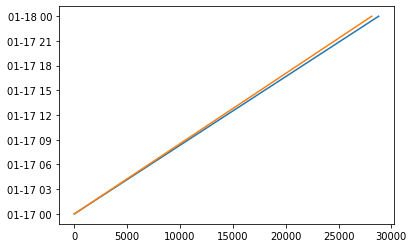

In [6]:
# compare sampling rates
plt.plot(epoch3sec_mag)
plt.plot(epoch3sec_plasma_momenta)

print(np.diff(epoch3sec_mag[:,0])[:5])
print(np.diff(epoch3sec_plasma_momenta)[:5]);

In [7]:
t0 = datetime.datetime(2013,1,15)

float_epoch3sec_mag = [dt.total_seconds() for dt in (epoch3sec_mag[:,0] - t0)]
print(float_epoch3sec_mag[:5])
float_epoch3sec_plasma_momenta = [dt.total_seconds() for dt in (epoch3sec_plasma_momenta - t0)]
print(float_epoch3sec_plasma_momenta[:5])

f = interpolate.interp1d(float_epoch3sec_mag,bTotal3sec[:,0])
bTotal_interpolated_to_t_plasma = np.array([f(t) for t in float_epoch3sec_plasma_momenta[1:]])
print(bTotal_interpolated_to_t_plasma.shape,'..')
# 注意 bTotal这边第一个被删掉了
print(vTotal3sec.shape)


f = interpolate.interp1d(float_epoch3sec_mag,bGSE3sec[:,0])
bGSE3_interpolated_to_t_plasma_x = np.array([f(t) for t in float_epoch3sec_plasma_momenta[1:]])
f = interpolate.interp1d(float_epoch3sec_mag,bGSE3sec[:,1])
bGSE3_interpolated_to_t_plasma_y = np.array([f(t) for t in float_epoch3sec_plasma_momenta[1:]])
f = interpolate.interp1d(float_epoch3sec_mag,bGSE3sec[:,2])
bGSE3_interpolated_to_t_plasma_z = np.array([f(t) for t in float_epoch3sec_plasma_momenta[1:]])
bGSE3_interpolated_to_t_plasma = np.array([bGSE3_interpolated_to_t_plasma_x,bGSE3_interpolated_to_t_plasma_y,bGSE3_interpolated_to_t_plasma_z])
bGSE3_interpolated_to_t_plasma = bGSE3_interpolated_to_t_plasma.T
bGSE3_interpolated_to_t_plasma.shape

[172801.5, 172804.5, 172807.5, 172810.5, 172813.5]
[172800.052, 172803.122, 172806.192, 172809.262, 172812.332]
(28143,) ..
(28144,)


(28143, 3)

In [8]:
# 只运行一遍
mu_0 = 4*np.pi*1e-7
m_proton = 1.6726219*1e-27
k_B = 1.38e-23

vTotal3sec = vTotal3sec[1:] # km/s
print(vTotal3sec.shape)
print('REMEMBER: you should run this line only ONCE!!!')
n3sec = n3sec[1:] # cm^-3
print(n3sec.shape)
epoch3sec_plasma_momenta = epoch3sec_plasma_momenta[1:]
print(epoch3sec_plasma_momenta.shape)
Tproton3sec = Tproton3sec[1:]
print(Tproton3sec.shape)

(28143,)
REMEMBER: you should run this line only ONCE!!!
(28143,)
(28143,)
(28143,)


In [9]:
nT_to_T = 1e-9
onethousandK_to_K = 1000
per_cmCubic_to_per_mCubic = 1e6

VA = (bTotal_interpolated_to_t_plasma*nT_to_T)/np.sqrt(mu_0*m_proton*n3sec*per_cmCubic_to_per_mCubic)
VA = VA/1000 # to km/s

mag_pressure = (bTotal_interpolated_to_t_plasma*nT_to_T)**2/(2*mu_0)
thermal_pressure = (n3sec*per_cmCubic_to_per_mCubic)*(k_B)*(Tproton3sec*onethousandK_to_K)

In [10]:
beta = thermal_pressure/mag_pressure

In [11]:
# fig, axes = plt.subplots(5,figsize=(10,13))
# ax = axes[0]
# ax.plot(epoch3sec_mag,bGSE3sec[:,0],label='Bx_GSE',linewidth=0.5)
# ax.plot(epoch3sec_mag,bGSE3sec[:,1],label='By_GSE',linewidth=0.5)
# ax.plot(epoch3sec_mag,bGSE3sec[:,2],label='Bz_GSE',linewidth=0.5)
# ax.plot(epoch3sec_mag,bTotal3sec,label='B_GSE',linewidth=0.5)
# ax.legend();

# ax = axes[1]
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[1:,0],label='Vx_GSE',linewidth=0.5)
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[1:,1],label='Vy_GSE',linewidth=0.5)
# ax.plot(epoch3sec_plasma_momenta,vGSE3sec[1:,2],label='Vz_GSE',linewidth=0.5)
# ax.plot(epoch3sec_plasma_momenta,vTotal3sec,label='V_GSE',linewidth=0.5)
# ax.legend();

# ax = axes[2]
# ax.plot(epoch3sec_plasma_momenta,n3sec,label='$N_p$[cm^-3]',linewidth=0.5)
# ax.legend();

# ax = axes[3]
# ax.plot(epoch3sec_plasma_momenta,VA,label='$V_A$[km/s]',linewidth=0.5)
# ax.legend();

# ax = axes[4]
# ax.plot(epoch3sec_plasma_momenta,vTotal3sec/VA,label='Alfvén Mach Number $M_A$',linewidth=0.5,color='k')
# ax.set_ylim([0,10])
# ax.plot(epoch3sec_plasma_momenta,[1,]*len(epoch3sec_plasma_momenta),'--',linewidth=0.5,label='$M_A=1$')
# ax.legend();

# plt.savefig('figures/2013_01_17_AlfvenMachNumber.png',dpi=1000);

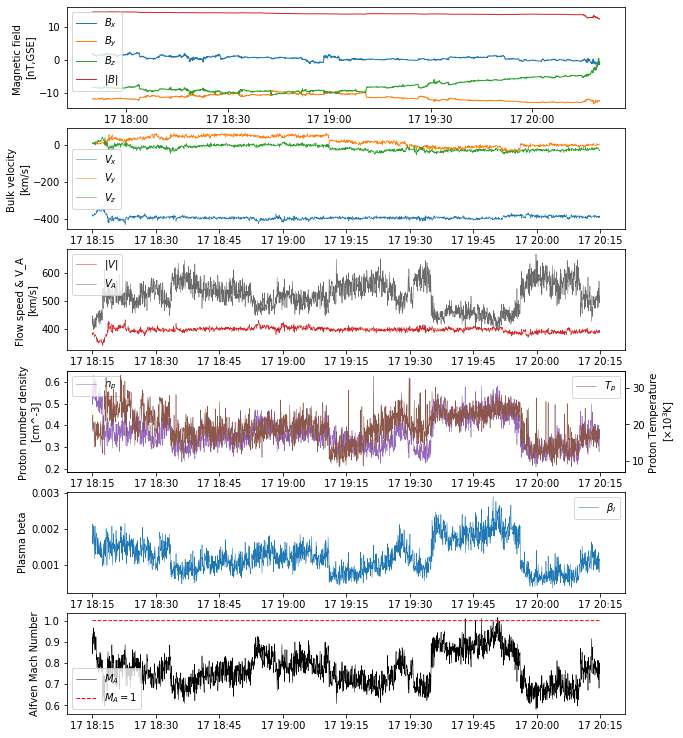

In [12]:
START = 21400
END = -4400

fig, axes = plt.subplots(6,figsize=(10,13))
ax = axes[0]
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,0],label='$B_x$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,1],label='$B_y$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,2],label='$B_z$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bTotal3sec[START:END],label='$|B|$',linewidth=1)
ax.set_ylabel('Magnetic field \n[nT,GSE]')
ax.legend();

ax = axes[1]
ax.plot(epoch3sec_plasma_momenta[START:END],vGSE3sec[1+START:END,0],label='$V_x$',linewidth=0.5)
ax.plot(epoch3sec_plasma_momenta[START:END],vGSE3sec[1+START:END,1],label='$V_y$',linewidth=0.5)
ax.plot(epoch3sec_plasma_momenta[START:END],vGSE3sec[1+START:END,2],label='$V_z$',linewidth=0.5)
ax.set_ylabel('Bulk velocity \n[km/s]')
ax.legend();

ax = axes[2]
ax.plot(epoch3sec_plasma_momenta[START:END],vTotal3sec[START:END],label='$|V|$',color='tab:red',linewidth=0.5)
ax.set_ylabel('Flow speed & V_A \n[km/s]')
ax.plot(epoch3sec_plasma_momenta[START:END],VA[START:END],label='$V_A$',color='dimgrey',linewidth=0.5)
ax.legend();


ax = axes[3]
ax.plot(epoch3sec_plasma_momenta[START:END],n3sec[START:END],label='$n_p$',color='tab:purple',linewidth=0.5)
ax.set_ylabel('Proton number density \n[cm^-3]')
ax.legend(loc='upper left');
another_ax = ax.twinx()
another_ax.plot(epoch3sec_plasma_momenta[START:END],Tproton3sec[START:END],label='$T_p$',color='tab:brown',linewidth=0.5)
another_ax.set_ylabel('Proton Temperature \n$[\\times 10^3$K]')
another_ax.legend()

ax = axes[4]
ax.plot(epoch3sec_plasma_momenta[START:END],beta[START:END],label='$\\beta_i$',linewidth=0.5)
ax.set_ylabel('Plasma beta')
ax.legend();

ax = axes[5]
ax.plot(epoch3sec_plasma_momenta[START:END],vTotal3sec[START:END]/VA[START:END],label='$M_A$',linewidth=0.5,color='k')
ax.set_ylabel('Alfven Mach Number')
ax.plot(epoch3sec_plasma_momenta[START:END],[1,]*len(epoch3sec_plasma_momenta[START:END]),'r--',linewidth=1,label='$M_A=1$')
ax.legend();


plt.savefig('figures/2013_01_17_1700to2400_AlfvenMachNumber.png',dpi=1000);

In [32]:
vGSE3sec_interested = vGSE3sec[1+START:END]
vTotal3sec_interested = vTotal3sec[START:END]
epoch3sec_plasma_momenta_interested = epoch3sec_plasma_momenta[START:END]
bGSE3_interpolated_to_t_plasma_interested = bGSE3_interpolated_to_t_plasma[START:END]
vGSE3sec_interested.shape,vTotal3sec_interested.shape,epoch3sec_plasma_momenta_interested.shape,bGSE3_interpolated_to_t_plasma_interested.shape

((2343, 3), (2343,), (2343,), (2343, 3))

In [33]:
width = 20
vGSE3sec_interested_avg = np.zeros(vGSE3sec_interested.shape)
for i in range(3):
    vGSE3sec_interested_avg[:,i] = moving_average(vGSE3sec_interested[:,i], width)
    vGSE3sec_interested_avg[:width//2,i] = vGSE3sec_interested[:width//2,i]
    vGSE3sec_interested_avg[-width//2:,i] = vGSE3sec_interested[-width//2:,i]
bGSE3_interpolated_to_t_plasma_interested_avg = np.zeros(bGSE3_interpolated_to_t_plasma_interested.shape)
for i in range(3):
    bGSE3_interpolated_to_t_plasma_interested_avg[:,i] = moving_average(bGSE3_interpolated_to_t_plasma_interested[:,i], width)
    bGSE3_interpolated_to_t_plasma_interested_avg[:width//2,i] = bGSE3_interpolated_to_t_plasma_interested[:width//2,i]
    bGSE3_interpolated_to_t_plasma_interested_avg[-width//2:,i] = bGSE3_interpolated_to_t_plasma_interested[-width//2:,i]

In [36]:
delta_VGSE3sec_interested = vGSE3sec_interested-vGSE3sec_interested_avg
delta_bGSE3_interpolated_to_t_plasma_interested = bGSE3_interpolated_to_t_plasma_interested - bGSE3_interpolated_to_t_plasma_interested_avg
multiplyer = nT_to_T/np.sqrt(mu_0*m_proton*n3sec[START:END]*per_cmCubic_to_per_mCubic)/1000
multiplyer = np.array([multiplyer,multiplyer,multiplyer])
multiplyer = multiplyer.T
# multiplyer: ~ /sqrt(mu_0*rho) [in Unit km/s]
z_plus_interested = delta_VGSE3sec_interested + delta_bGSE3_interpolated_to_t_plasma_interested*multiplyer
z_minus_interested = delta_VGSE3sec_interested - delta_bGSE3_interpolated_to_t_plasma_interested*multiplyer

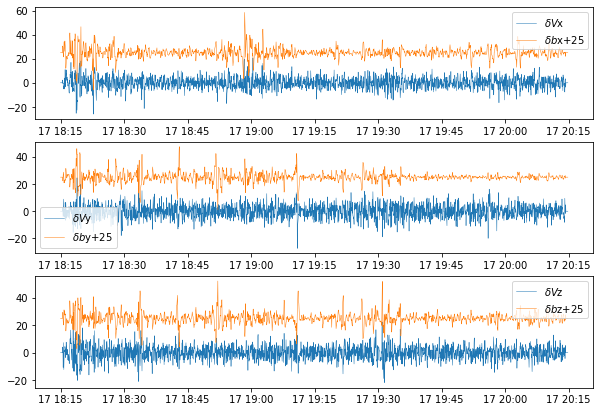

In [38]:
fig,axes = plt.subplots(3,figsize=(10,7))
for i in range(3):
    ax=axes[i]
    ax.plot(epoch3sec_plasma_momenta_interested,delta_VGSE3sec_interested[:,i],label='$\delta V$'+{0:'x',1:'y',2:'z'}[i],linewidth=0.5)
    ax.plot(epoch3sec_plasma_momenta_interested,
           delta_bGSE3_interpolated_to_t_plasma_interested[:,i]
            *nT_to_T/np.sqrt(mu_0*m_proton*n3sec[START:END]*per_cmCubic_to_per_mCubic)
            /1000+25,label='$\delta b$'+{0:'x',1:'y',2:'z'}[i]+'+25',
           linewidth=0.5)
    ax.legend();
_ = 0;

In [39]:
# delta_VGSE3sec_interested[np.isnan(delta_VGSE3sec_interested)]=0
# delta_bGSE3_interpolated_to_t_plasma_interested[np.isnan(delta_bGSE3_interpolated_to_t_plasma_interested)]=0

# for i in range(3):
#     for j in range(3):
#         print(i,j,np.corrcoef(delta_VGSE3sec_interested[:,i],delta_bGSE3_interpolated_to_t_plasma_interested[:,j])[0,1])

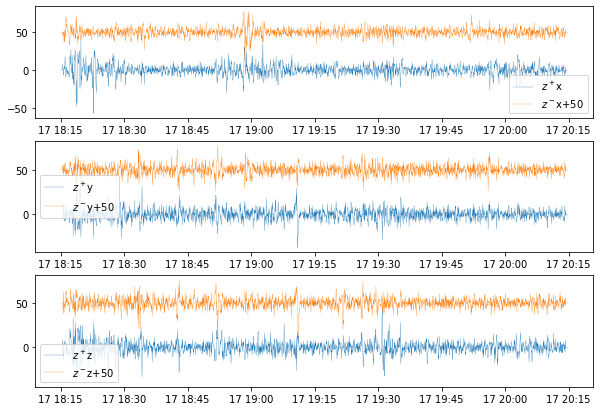

In [41]:
fig,axes = plt.subplots(3,figsize=(10,7))
for i in range(3):
    ax=axes[i]
    ax.plot(epoch3sec_plasma_momenta_interested,z_plus_interested[:,i],linewidth=0.3,label='$z^+$'+{0:'x',1:'y',2:'z'}[i])
    ax.plot(epoch3sec_plasma_momenta_interested,z_minus_interested[:,i]+50,linewidth=0.3,label='$z^-$'+{0:'x',1:'y',2:'z'}[i]+'+50')
    ax.legend();
_ = 0;

In [42]:
z_plus_interested.shape

(2343, 3)

In [43]:
z_plus_square = np.sum(z_plus_interested**2,axis=1)
z_minus_square = np.sum(z_minus_interested**2,axis=1)

In [44]:
width = [20,40,80,160,320,640]
time_scale = np.array(width)/20
sigma_c_list = []
sigma_r_list = []
dot_multply_plus_and_minus = np.array([z_plus_interested[:,j]*z_minus_interested[:,j] for j in range(3)])
dot_multply_plus_and_minus = np.nansum(dot_multply_plus_and_minus,axis=0)
for i in range(len(width)):
    sigma_c_upper = moving_average(z_plus_square,width[i])-moving_average(z_minus_square,width[i])
    sigma_c_lower = sigma_c_upper+2*moving_average(z_minus_square,width[i])
    sigma_c = sigma_c_upper/sigma_c_lower
    sigma_c_list.append(sigma_c)
    
    sigma_r_upper = moving_average(dot_multply_plus_and_minus,width[i])
    sigma_r = sigma_r_upper/sigma_c_lower
    sigma_r_list.append(sigma_r)

/Users/linrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/linrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(6, 2343)

[]

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Time scale (min)')

Text(0.5, 1.0, '$\\sigma_c$')

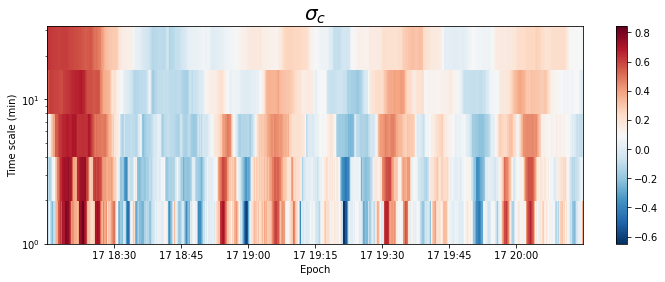

In [45]:
sigma_c_arr = np.array(sigma_c_list)
sigma_c_arr.shape
fig = plt.figure(figsize=(12,4))
plt.pcolormesh(epoch3sec_plasma_momenta_interested,time_scale,sigma_c_arr,cmap='RdBu_r')
plt.colorbar()
plt.semilogy()
plt.xlabel('Epoch')
plt.ylabel('Time scale (min)')
plt.title('$\\sigma_c$',fontsize=20)

Text(0.5, 0, 'Time scale (min)')

Text(0.5, 1.0, 'Sum of $\\sigma_c$')

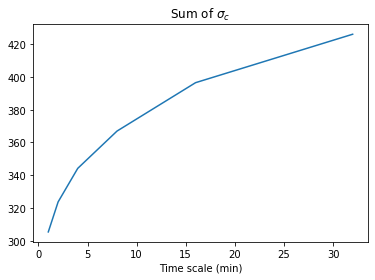

In [46]:
plt.plot(time_scale,np.nansum(sigma_c_arr,axis=1))
plt.xlabel('Time scale (min)')
plt.title('Sum of $\\sigma_c$')
# 但是中间那些去掉，就很红了。

(6, 2343)

[]

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Time scale (min)')

Text(0.5, 1.0, '$\\sigma_r$')

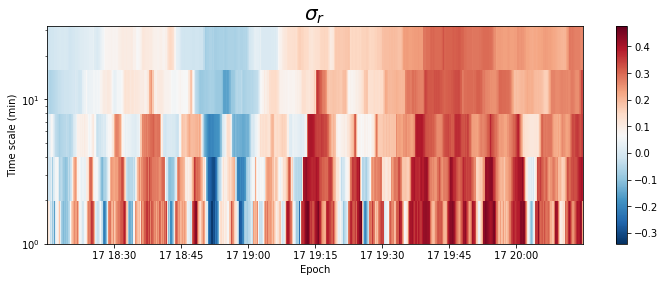

In [47]:
sigma_r_arr = np.array(sigma_r_list)
sigma_r_arr.shape
fig = plt.figure(figsize=(12,4))
plt.pcolormesh(epoch3sec_plasma_momenta_interested,time_scale,sigma_r_arr,cmap='RdBu_r')
plt.colorbar()
plt.semilogy()
plt.xlabel('Epoch')
plt.ylabel('Time scale (min)')
plt.title('$\\sigma_r$',fontsize=20)

Text(0.5, 0, 'Time scale (min)')

Text(0.5, 1.0, 'Sum of $\\sigma_r$')

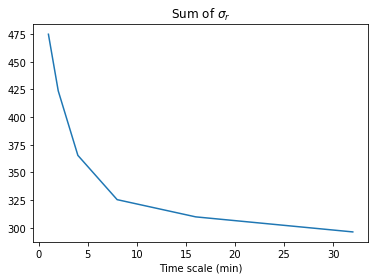

In [48]:
plt.plot(time_scale,np.nansum(sigma_r_arr,axis=1))
plt.xlabel('Time scale (min)')
plt.title('Sum of $\\sigma_r$')


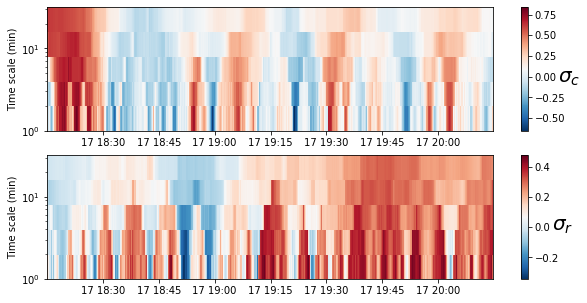

In [49]:
fig, axes = plt.subplots(2,figsize=(10,5))
ax = axes[0]
pclr = ax.pcolormesh(epoch3sec_plasma_momenta_interested,time_scale,sigma_c_arr,cmap='RdBu_r')
clb = plt.colorbar(pclr, ax=ax)
clb.ax.set_ylabel('$\\sigma_c$',fontsize=20,rotation=0)
ax.semilogy()
ax.set_ylabel('Time scale (min)')
# ax.set_title()

ax = axes[1]
pclr = ax.pcolormesh(epoch3sec_plasma_momenta_interested,time_scale,sigma_r_arr,cmap='RdBu_r')
clb = plt.colorbar(pclr, ax=ax)
ax.semilogy()
ax.set_ylabel('Time scale (min)')
clb.ax.set_ylabel('$\\sigma_r$',fontsize=20,rotation=0);

Text(0.5, 0, 'Time scale (min)')

Text(0, 0.5, 'Sum of $\\sigma_c$')

Text(0, 0.5, 'Sum of $\\sigma_r$')

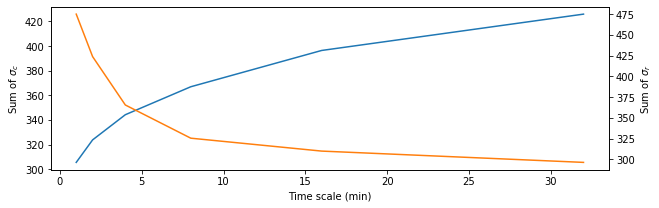

In [50]:
fig,ax = plt.subplots(1,figsize=(10,3))
ax.plot(time_scale,np.nansum(sigma_c_arr,axis=1))
ax.set_xlabel('Time scale (min)')
ax.set_ylabel('Sum of $\\sigma_c$')
another_ax = ax.twinx()
another_ax.plot(time_scale,np.nansum(sigma_r_arr,axis=1),color='tab:orange')
another_ax.set_ylabel('Sum of $\\sigma_r$')


In [51]:
dt_l = [dt.total_seconds() for dt in np.diff(epoch3sec_plasma_momenta_interested)]
np.mean(dt_l)
dt = 3.07

3.0699619982920585